In [26]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
p = 0.01

df = pd.read_csv(
    'MICRODADOS_ENEM_2019.csv',
    header=0,
    encoding = "ISO-8859-1",
    skiprows=lambda i: i > 0 and random.random() > p,
    sep=';'
)

df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001004762,2019,1506807,Santarém,15,PA,31,F,1,1,...,B,A,A,D,B,A,D,A,B,B
1,190001004802,2019,1501402,Belém,15,PA,26,F,0,3,...,A,A,A,B,A,A,B,A,A,A
2,190001005137,2019,1501402,Belém,15,PA,17,F,1,1,...,B,A,A,D,B,A,E,B,C,B
3,190001005192,2019,1501402,Belém,15,PA,28,F,0,3,...,A,A,A,B,A,A,D,A,A,B
4,190001005240,2019,1501402,Belém,15,PA,20,M,1,3,...,A,A,A,B,A,A,B,A,A,A


In [28]:
df.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'],
      dtype='object', length=136)

In [41]:
def subgrupo(x):
    if x =='A':
        return 0
    if any((x =='B',x=='C',x=='D',x=='E')):
        return 0
    if any((x=='F',x=='G',x=='H',x=='I')):
        return 1
    if any((x=='J',x=='K',x=='L',x=='M')):
        return 3
    if any((x=='N',x=='O',x=='P',x=='Q')):
        return 4
    
df['Subgrupo'] = df['Q006'].apply(subgrupo)
df

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,media,Subgrupo
9,190001005689,2019,1501709,Bragança,15,PA,21,F,0,3,...,A,B,A,A,B,A,A,A,326.58,0
13,190001006068,2019,1507953,Tailândia,15,PA,24,M,1,3,...,A,B,B,A,C,A,A,B,425.46,0
14,190001006087,2019,1504422,Marituba,15,PA,17,F,1,1,...,B,B,A,B,E,A,B,B,608.26,3
20,190001006385,2019,1505403,Ourém,15,PA,17,F,1,3,...,A,A,A,A,A,A,A,A,536.06,0
24,190001006542,2019,1500800,Ananindeua,15,PA,17,F,1,1,...,A,D,A,B,C,B,A,B,664.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,190006114217,2019,2610707,Paulista,26,PE,17,F,1,3,...,A,B,A,A,C,A,A,B,465.68,0
50633,190006116374,2019,5107602,Rondonópolis,51,MT,18,M,1,1,...,B,C,A,B,E,A,A,B,623.24,3
50644,190006117557,2019,3507605,Bragança Paulista,35,SP,17,F,1,1,...,B,C,B,B,C,B,B,B,474.00,0
50663,190006119974,2019,2918001,Jequié,29,BA,19,M,1,1,...,A,B,A,A,C,A,B,B,509.88,0


In [29]:
# 	Nenhuma renda.
# Vou comparar com o Q

# B	Até R$ 998,00
# C	De R$ 998,01 até R$ 1.497,00.
# D	De R$ 1.497,01 até R$ 1.996,00.
# E	De R$ 1.996,01 até R$ 2.495,00.

# F	De R$ 2.495,01 até R$ 2.994,00.
# G	De R$ 2.994,01 até R$ 3.992,00.
# H	De R$ 3.992,01 até R$ 4.990,00.
# I	De R$ 4.990,01 até R$ 5.988,00.

# J	De R$ 5.988,01 até R$ 6.986,00.
# K	De R$ 6.986,01 até R$ 7.984,00.
# L	De R$ 7.984,01 até R$ 8.982,00.
# M	De R$ 8.982,01 até R$ 9.980,00.

# N	De R$ 9.980,01 até R$ 11.976,00.
# O	De R$ 11.976,01 até R$ 14.970,00.
# P	De R$ 14.970,01 até R$ 19.960,00.
# Q	Mais de R$ 19.960,00.


#Dropei valores nulos, assim como a média, notas (pessoas que n compareceram, ou zeraram a redação)
df = df.dropna()

#media
media = (df.NU_NOTA_CN+df.NU_NOTA_CH+df.NU_NOTA_LC+df.NU_NOTA_MT+df.NU_NOTA_REDACAO)/5
df['media'] = media

# Subgrupo 0

grupo_A = df.loc[df['Q006'] == 'A']

#Subgrupo 1
grupo_B = df.loc[df['Q006'] == 'B']
grupo_C = df.loc[df['Q006'] == 'C']
grupo_D = df.loc[df['Q006'] == 'D']
grupo_E = df.loc[df['Q006'] == 'E']


#Subgrupo 2
grupo_F = df.loc[df['Q006'] == 'F']
grupo_G = df.loc[df['Q006'] == 'G']
grupo_H = df.loc[df['Q006'] == 'H']
grupo_I = df.loc[df['Q006'] == 'I']

#Subgrupo3
grupo_J = df.loc[df['Q006'] == 'J']
grupo_K = df.loc[df['Q006'] == 'K']
grupo_L = df.loc[df['Q006'] == 'L']
grupo_M = df.loc[df['Q006'] == 'M']


#Subgrupo 

grupo_N = df.loc[df['Q006'] == 'N']
grupo_O = df.loc[df['Q006'] == 'O']
grupo_P = df.loc[df['Q006'] == 'P']
grupo_Q = df.loc[df['Q006'] == 'Q']







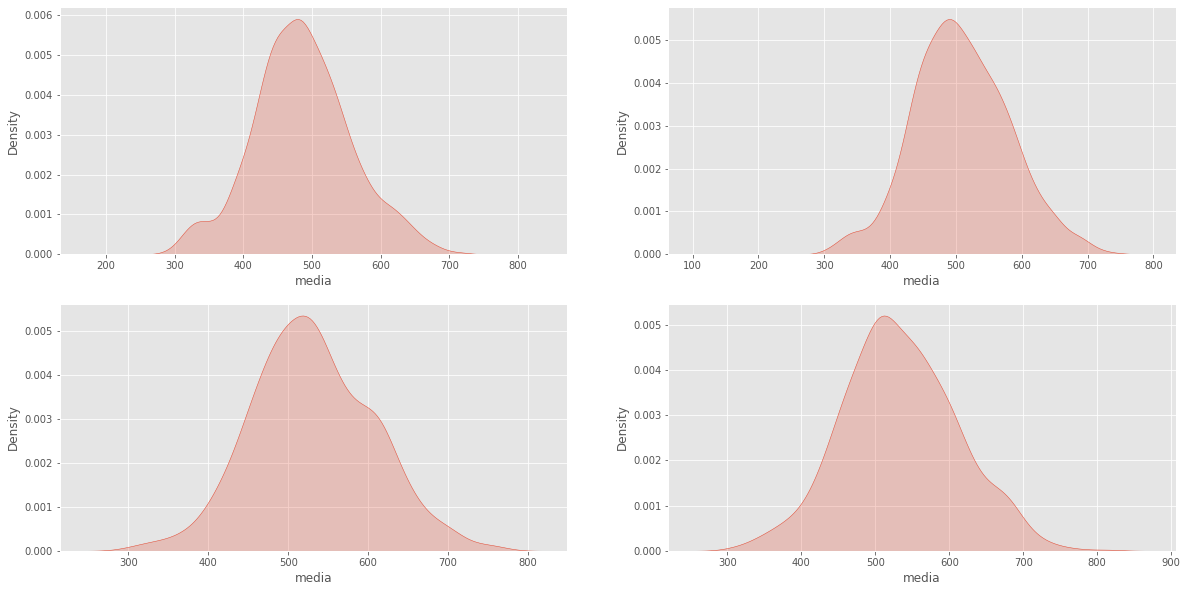

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10
sns.kdeplot(grupo_B['media'], ax=ax[0,0], shade=True) # plota a distribuiçao da coluna age
sns.kdeplot(grupo_C['media'], ax=ax[0,1], shade=True) # plota a distribuiçao da coluna age
sns.kdeplot(grupo_D['media'], ax=ax[1,0], shade=True) # plota a distribuiçao da coluna age
sns.kdeplot(grupo_E['media'], ax=ax[1,1], shade=True) # plota a distribuiçao da coluna age


<AxesSubplot:xlabel='media', ylabel='Density'>

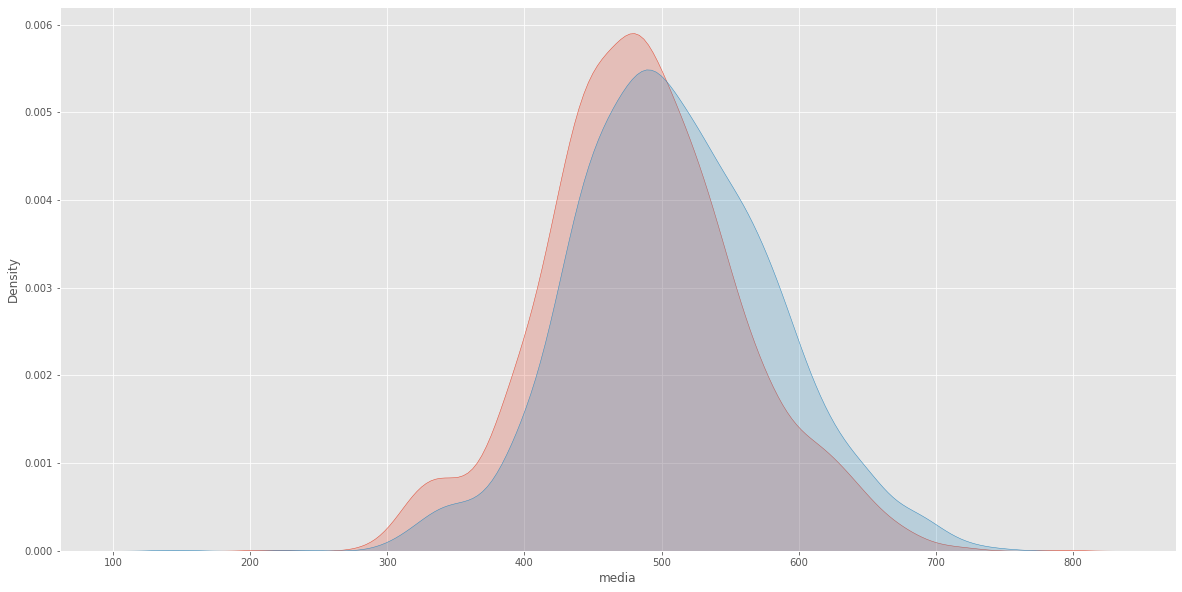

In [31]:
fig, ax = plt.subplots( figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10
sns.kdeplot(grupo_B['media'], ax=ax, shade=True) # plota a distribuiçao da coluna age
sns.kdeplot(grupo_C['media'], ax=ax, shade=True) # plota a distribuiçao da coluna age


### GRÁFICO COMPARANDO OS SUBGRUPOS

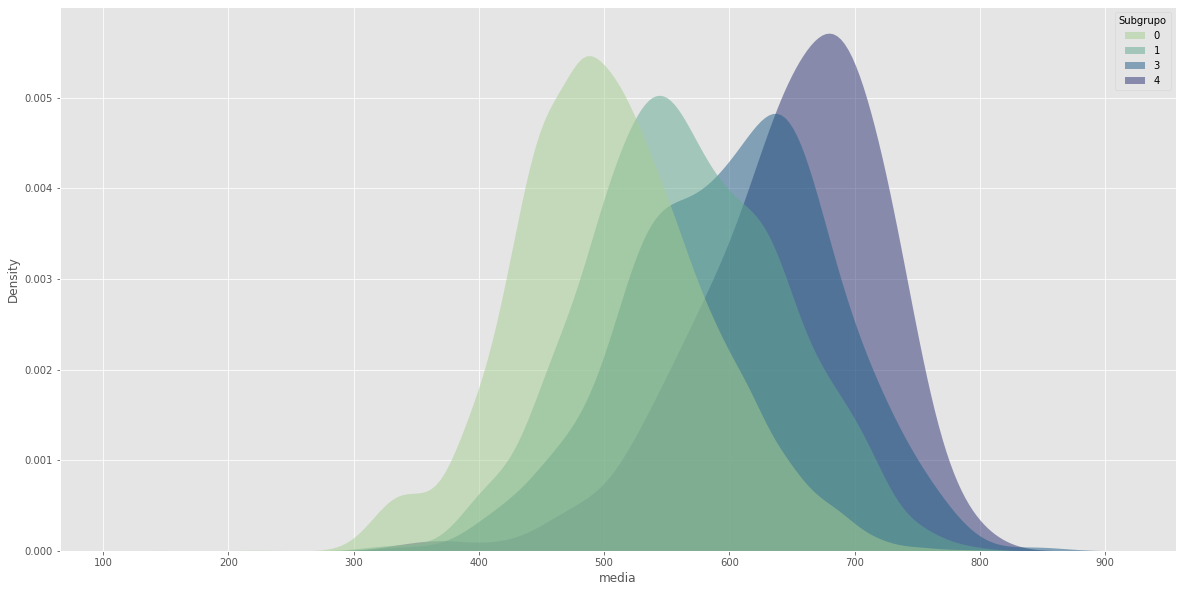

In [43]:
fig, ax = plt.subplots( figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10

sns.kdeplot(
   data=df, x="media", hue="Subgrupo",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
plt.show()